# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy import optimize
from astropy.io import fits
import astropy.coordinates as coord
import pandas as pd
import os
from tabulate import tabulate
from jwst.residual_fringe.utils import fit_residual_fringes_1d as rf1d
import healpy as hp

# Parameters

In [2]:
t1 = 5  #truncation wvl 1
t2 = 27.8  #truncation wvl 2
#outDir = '../analysis_data/+'axionJWST'+str(t1)+'_'+str(t2)

# Functions

In [18]:
#Reading data files

def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while arr[i] < x:
        i += 1
    return i
    
# def readSpec(csvFile):
#     #csvFile: objName, expt_ch1, expt_ch2, expt_ch3, expt_ch4, longitude, latitude, ...
#     specFile = pd.read_csv(csvFile)
#     dataInfo = np.array(specFile)
#     fileNo = np.ma.size(dataInfo,axis=0)
#     exptArr = np.zeros((fileNo,4))
#     longArr = np.zeros(fileNo)
#     latArr = np.zeros(fileNo)
#     for i in range(fileNo):
#         exptArr[i,0] = dataInfo[i,1]  #s
#         exptArr[i,1] = dataInfo[i,2]  #s
#         exptArr[i,2] = dataInfo[i,3]  #s
#         exptArr[i,3] = dataInfo[i,4]  #s
#         longArr[i] = dataInfo[i,5]  #rad
#         latArr[i] = dataInfo[i,6]  #rad
#     print('No. of files:', fileNo)
#     print('Total exposure time:', np.sum(exptArr)/4)
#     return exptArr, longArr, latArr

def defringe(wvl, flux, error, CH, M1=np.inf, M2=np.inf):
    flux_c = rf1d(flux,wvl,channel=CH)
    if not (M1==np.inf):
        p1 = locate(wvl,M1) 
        p2 = locate(wvl,M2)
        wvlCut = wvl[p1:p2]
        fluxCut_c = flux_c[p1:p2]
        fluxCut = flux[p1:p2]
        errorCut = error[p1:p2]   
        plt.figure(figsize=(9,6))
        plt.plot(wvlCut,fluxCut_c,label='rf1d')
        plt.fill_between(wvlCut,fluxCut_c+errorCut,fluxCut_c-errorCut,step="pre",color='silver')
        plt.plot(wvlCut,fluxCut,'--',label='raw')
        plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
        plt.legend()
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.show()
    return flux_c
    
def truncation(wvl, flux, error, wvlT1=np.inf, wvlT2=np.inf):
    if (wvlT1==np.inf):
        p1 = 0
    else:
        p1 = locate(wvl,wvlT1)
    if (wvlT2==np.inf):
        p2 = len(wvl)
    else:
        p2 = locate(wvl,wvlT2)
    wvl_t = wvl[p1:p2]
    flux_t = flux[p1:p2]
    error_t = error[p1:p2]
    return wvl_t, flux_t, error_t
    
def readFits(DirName, plotSpec=True, defringe=True, sysErr=np.inf, M1=np.inf, M2=np.inf):  #Read a single .fits

    #Read fits:
    visFile = [file for file in os.listdir(DirName) if not file.startswith('.')]
    for fitsFile in visFile:
        if 'ch1' in fitsFile:
            hdul_ch1 = fits.open(DirName+'/'+fitsFile)
        elif 'ch2' in fitsFile:
            hdul_ch2 = fits.open(DirName+'/'+fitsFile)
        elif 'ch3' in fitsFile:
            hdul_ch3 = fits.open(DirName+'/'+fitsFile)
        elif 'ch4' in fitsFile:
            hdul_ch4 = fits.open(DirName+'/'+fitsFile)

    #Data arrays:
    wvlName = 'WAVELENGTH'
    fluxName = 'FLUX'
    errorName = 'FLUX_ERROR'
    exptName = 'EFFEXPTM'
    raName = 'SLIT_RA'
    decName = 'SLIT_DEC'
    arcsec_to_usr = 1e-4/4.25
    fov1 =  3.2*3.7*arcsec_to_usr  #u*sr
    fov2 =  4.0*4.8*arcsec_to_usr  #u*sr
    fov3 =  5.2*6.2*arcsec_to_usr  #u*sr
    fov4 =  6.6*7.7*arcsec_to_usr  #u*sr
    wvl_ch1 = hdul_ch1[1].data[wvlName]
    flux_ch1 = hdul_ch1[1].data[fluxName]/fov1
    err_ch1 = hdul_ch1[1].data[errorName]/fov1
    wvl_ch2 = hdul_ch2[1].data[wvlName]
    flux_ch2 = hdul_ch2[1].data[fluxName]/fov2
    err_ch2 = hdul_ch2[1].data[errorName]/fov2
    wvl_ch3 = hdul_ch3[1].data[wvlName]
    flux_ch3 = hdul_ch3[1].data[fluxName]/fov3
    err_ch3 = hdul_ch3[1].data[errorName]/fov3
    wvl_ch4 = hdul_ch4[1].data[wvlName]
    flux_ch4 = hdul_ch4[1].data[fluxName]/fov4
    err_ch4 = hdul_ch4[1].data[errorName]/fov4
    #Defringing+truncation:
    if (defringe==True):
        flux_ch1_c = rf1d(flux_ch1,wvl_ch1,channel=1)
        flux_ch2_c = rf1d(flux_ch2,wvl_ch2,channel=2)
        flux_ch3_c = rf1d(flux_ch3,wvl_ch3,channel=3)
        flux_ch4_c = rf1d(flux_ch4,wvl_ch4,channel=4)
        wvl_ch1_p, flux_ch1_p, err_ch1_p = truncation(wvl_ch1, flux_ch1_c, err_ch1, wvlT1=t1)
        wvl_ch2_p, flux_ch2_p, err_ch2_p = truncation(wvl_ch2, flux_ch2_c, err_ch2)
        wvl_ch3_p, flux_ch3_p, err_ch3_p = truncation(wvl_ch3, flux_ch3_c, err_ch3)
        wvl_ch4_p, flux_ch4_p, err_ch4_p = truncation(wvl_ch4, flux_ch4_c, err_ch4, wvlT2=t2)
    else:
        wvl_ch1_p, flux_ch1_p, err_ch1_p = truncation(wvl_ch1, flux_ch1, err_ch1, wvlT1=t1)
        wvl_ch2_p, flux_ch2_p, err_ch2_p = truncation(wvl_ch2, flux_ch2, err_ch2)
        wvl_ch3_p, flux_ch3_p, err_ch3_p = truncation(wvl_ch3, flux_ch3, err_ch3)
        wvl_ch4_p, flux_ch4_p, err_ch4_p = truncation(wvl_ch4, flux_ch4, err_ch4, wvlT2=t2)
    if not (sysErr==np.inf):
        err_ch1_p += flux_ch1_p*sysErr
        err_ch2_p += flux_ch2_p*sysErr
        err_ch3_p += flux_ch3_p*sysErr
        err_ch4_p += flux_ch4_p*sysErr
    data_ch1 = np.array([wvl_ch1_p,flux_ch1_p,err_ch1_p])
    data_ch2 = np.array([wvl_ch2_p,flux_ch2_p,err_ch2_p])
    data_ch3 = np.array([wvl_ch3_p,flux_ch3_p,err_ch3_p])
    data_ch4 = np.array([wvl_ch4_p,flux_ch4_p,err_ch4_p])
    exptime = np.array([hdul_ch1[0].header[exptName],hdul_ch2[0].header[exptName],hdul_ch3[0].header[exptName],hdul_ch4[0].header[exptName]])
    ra = hdul_ch1[1].header[raName]  #deg
    dec = hdul_ch1[1].header[decName]  #deg
    
    #Preview truncated spectrum:
    if (plotSpec==True):
        #Basic info:
        print("Channel 1:")
        print("Wavelength range:", (wvl_ch1[0],wvl_ch1[-1]))
        print("Array shape:", wvl_ch1.shape)
        print("Bin size (dlmd):", wvl_ch1[1]-wvl_ch1[0])
        print("Channel 2:")
        print("Wavelength range:", (wvl_ch2[0],wvl_ch2[-1]))
        print("Array shape:", wvl_ch2.shape)
        print("Bin size (dlmd):", wvl_ch2[1]-wvl_ch2[0])
        print("Channel 3:")
        print("Wavelength range:", (wvl_ch3[0],wvl_ch3[-1]))
        print("Array shape:", wvl_ch3.shape)
        print("Bin size (dlmd):", wvl_ch3[1]-wvl_ch3[0])
        print("Channel 4:")
        print("Wavelength range:", (wvl_ch4[0],wvl_ch4[-1]))
        print("Array shape:", wvl_ch4.shape)
        print("Bin size (dlmd):", wvl_ch4[1]-wvl_ch4[0])

        sbName = 'SURF_BRIGHT'
        bkgdName = 'BACKGROUND'
        sb_ch1 = hdul_ch1[1].data[sbName]
        sb_ch2 = hdul_ch2[1].data[sbName]
        sb_ch3 = hdul_ch3[1].data[sbName]
        sb_ch4 = hdul_ch4[1].data[sbName]
        bkgd_ch1 = hdul_ch1[1].data[bkgdName]
        bkgd_ch2 = hdul_ch2[1].data[bkgdName]
        bkgd_ch3 = hdul_ch3[1].data[bkgdName]
        bkgd_ch4 = hdul_ch4[1].data[bkgdName]

        plt.figure(figsize=(9,9))
        plt.subplot(411)
        plt.step(wvl_ch1_p,flux_ch1_p)
        plt.step(wvl_ch2_p,flux_ch2_p)
        plt.step(wvl_ch3_p,flux_ch3_p)
        plt.step(wvl_ch4_p,flux_ch4_p)
        plt.yscale('log')
        plt.title('Total flux (processed)')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(412)
        plt.step(wvl_ch1,flux_ch1)
        plt.step(wvl_ch2,flux_ch2)
        plt.step(wvl_ch3,flux_ch3)
        plt.step(wvl_ch4,flux_ch4)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(413)
        plt.step(wvl_ch1,sb_ch1)
        plt.step(wvl_ch2,sb_ch2)
        plt.step(wvl_ch3,sb_ch3)
        plt.step(wvl_ch4,sb_ch4)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'SURF_BRIGHT\' against \'WAVELENGTH\'') #plt.title('Subject')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(414)
        plt.step(wvl_ch1,bkgd_ch1)
        plt.step(wvl_ch2,bkgd_ch2)
        plt.step(wvl_ch3,bkgd_ch3)
        plt.step(wvl_ch4,bkgd_ch4)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'BACKGROUND\' against \'WAVELENGTH\'') #plt.title('Background')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.tight_layout(pad=0.9)
        plt.savefig('exampleSpectrum_2')
        if not (M1==np.inf):
            wvlp = np.concatenate((wvl_ch1_p,wvl_ch2_p,wvl_ch3,wvl_ch4_p))
            fluxp = np.concatenate((flux_ch1_p,flux_ch2_p,flux_ch3,flux_ch4_p))
            errp = np.concatenate((err_ch1_p,err_ch2_p,err_ch3_p,err_ch4_p))
            p1p = locate(wvlp,M1) 
            p2p = locate(wvlp,M2)
            wvlCutp = wvlp[p1p:p2p]
            fluxCutp = fluxp[p1p:p2p]
            errorCutp = errp[p1p:p2p]
            wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
            flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))
            err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
            p1 = locate(wvl,M1) 
            p2 = locate(wvl,M2)
            wvlCut = wvl[p1:p2]
            fluxCut = flux[p1:p2]
            errorCut = err[p1:p2]
            plt.figure(figsize=(9,6))
            plt.plot(wvlCutp,fluxCutp,label='rf1d')
            plt.plot(wvlCut,fluxCut,'--',label='raw')
            plt.fill_between(wvlCutp,fluxCutp+errorCutp,fluxCutp-errorCutp,step="pre",color='silver')
            plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
            plt.legend()
            plt.xlabel("Wavelength ($\\mu$m)")
            plt.ylabel("$\\Phi$ (MJy/sr)")
            
    return data_ch1, data_ch2, data_ch3, data_ch4, exptime, ra, dec

def readFitsDir(Dir,printTable=True,skymap=True,defr=True,sysError=np.inf):  #Read a directory containing multiple .fits
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    data_ch1, data_ch2, data_ch3, data_ch4,_,_,_ = readFits(Dir+'/'+visFile[0],plotSpec=False,defringe=defr,sysErr=sysError)
    fileNo = len(visFile)
    binNo1 = np.ma.size(data_ch1,axis=1)
    binNo2 = np.ma.size(data_ch2,axis=1)
    binNo3 = np.ma.size(data_ch3,axis=1)
    binNo4 = np.ma.size(data_ch4,axis=1)
    Ch1Arr = np.zeros((fileNo,3,binNo1))
    Ch2Arr = np.zeros((fileNo,3,binNo2))
    Ch3Arr = np.zeros((fileNo,3,binNo3))
    Ch4Arr = np.zeros((fileNo,3,binNo4))
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    for i in range(fileNo):
        fileName = visFile[i]
        Ch1Arr[i,:,:], Ch2Arr[i,:,:], Ch3Arr[i,:,:], Ch4Arr[i,:,:], exptArr[i,:], longArr[i], latArr[i] = readFits(Dir+'/'+fileName,plotSpec=False,defringe=defr,sysErr=sysError)
    sc = coord.SkyCoord(ra=longArr, dec=latArr, unit="deg").galactic
    longArr = sc.l.rad
    latArr = sc.b.rad
    if (printTable==True):
        myTable = np.transpose(np.array([np.mean(exptArr,axis=1),longArr,latArr]))
        head = np.array(['Exptime (s)','Longtitude (rad)','Latitude (rad)'])
        print(tabulate(myTable,headers=head))
    print('Total exptime:', np.sum(np.mean(exptArr,axis=1)), '(s)')
    print('No. of file:', fileNo)
    if (skymap==True):
        NSIDE = 256
        N = 20
        m = np.zeros(hp.nside2npix(NSIDE))
        for i in range(fileNo):
            vec = hp.ang2vec(longArr[i]*180/np.pi,latArr[i]*180/np.pi,lonlat=True)
            ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(2))
            m[ipix_disc] = np.mean(exptArr[i,:])
        hp.mollview(m, title="Sampled data",unit='Exp time (s)')
        # hp.projplot(np.array([0,100]),np.array([10,10]),'--',lonlat=True) 
        # hp.projplot(np.array([0,100]),np.array([-10,-10]),'--',lonlat=True) 
        #hp.projscatter(longArr, latArr, lonlat=True, coord='G')
        hp.graticule(dpar=15)
        plt.show()
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr
        
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=True,interp=False,setWvl=0):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    flux_ch1 = np.zeros(binNo1)
    flux_ch2 = np.zeros(binNo2)
    flux_ch3 = np.zeros(binNo3)
    flux_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    exptime = np.zeros(fileNo)
    SNR = np.zeros(fileNo)
    
    for i in range(fileNo):
        exptTotal = np.sum(exptArr[0:i+1,:],axis=0)
        exptime[i] = np.mean(exptTotal)
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
            Ch1Arr[i,2,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,2,:])
            Ch2Arr[i,2,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,2,:])
            Ch3Arr[i,2,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,2,:])
            Ch4Arr[i,2,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,2,:])
        flux_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        flux_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        flux_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        flux_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,1]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,1]
        NSR = abs(np.concatenate((np.sqrt(dn_total_ch1)/flux_ch1,np.sqrt(dn_total_ch2)/flux_ch2,np.sqrt(dn_total_ch3)/flux_ch3,np.sqrt(dn_total_ch4)/flux_ch4)))
        SNR[i] = 1/np.mean(NSR)
    wvl_ch1 = Ch1Arr[setWvl,0,:]
    wvl_ch2 = Ch2Arr[setWvl,0,:]
    wvl_ch3 = Ch3Arr[setWvl,0,:]
    wvl_ch4 = Ch4Arr[setWvl,0,:]
    flux_ch1 = flux_ch1/exptTotal[0]
    flux_ch2 = flux_ch2/exptTotal[1]
    flux_ch3 = flux_ch3/exptTotal[2]
    flux_ch4 = flux_ch4/exptTotal[3]
    err_ch1 = np.sqrt(dn_total_ch1)/exptTotal[0]
    err_ch2 = np.sqrt(dn_total_ch2)/exptTotal[1]
    err_ch3 = np.sqrt(dn_total_ch3)/exptTotal[2]
    err_ch4 = np.sqrt(dn_total_ch4)/exptTotal[3]
    if (defr==True):
        flux_ch1 = defringe(wvl_ch1,flux_ch1,err_ch1,CH=1)
        flux_ch2 = defringe(wvl_ch2,flux_ch2,err_ch2,CH=2,M1=8.25,M2=8.75)
        #flux_ch3 = defringe(wvl_ch3,flux_ch3,err_ch3,CH=3)
        flux_ch4 = defringe(wvl_ch4,flux_ch4,err_ch4,CH=4)
    stkdata_ch1 = np.array([wvl_ch1,flux_ch1,err_ch1])
    stkdata_ch2 = np.array([wvl_ch2,flux_ch2,err_ch2])
    stkdata_ch3 = np.array([wvl_ch3,flux_ch3,err_ch3])
    stkdata_ch4 = np.array([wvl_ch4,flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5.350, M2=5.525, Ch1Arr=[],Ch2Arr=[],Ch3Arr=[],Ch4Arr=[]):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))  
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    
    plt.figure(figsize=(9,6))
    plt.subplot(211)  
    #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
    plt.step(wvl,flux,'black',label='Stacked',linewidth=2.5)
    #plt.axhline(y=0,linestyle='--')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(0, 0.3)
    plt.legend()
    
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black',label='Stacked')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver',linewidth=2.5)
    #plt.ylim(0.08,0.14)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    plt.tight_layout(pad=0.9)
    plt.legend()

    if not(len(Ch1Arr)==0):
            fileNo = np.ma.size(Ch1Arr,axis=0)
            data_unstk = np.concatenate((Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr),axis=2)
            for  i in range(fileNo):
                wvlCut_unstk, fluxCut_unstk, errorCut_unstk = data_unstk[i,:,p1:p2]
                plt.subplot(211) 
                plt.step(data_unstk[i,0,:],data_unstk[i,1,:],linestyle='dotted',linewidth=0.3)
                plt.subplot(212)
                plt.step(wvlCut_unstk,fluxCut_unstk,linestyle='dotted',linewidth=0.5)
                plt.fill_between(wvlCut_unstk,fluxCut_unstk+errorCut_unstk,fluxCut_unstk-errorCut_unstk,step="pre",color='silver')

def linReg(xarr,yarr):
    f = lambda p,x : p[0]*x+p[1]
    lsq = lambda p : np.sum((yarr - f(p,xarr))**2)
    minitial = (yarr[-1]-yarr[0])/(xarr[-1]-xarr[0])
    pinitial = np.array([minitial,yarr[0]-minitial*xarr[0]])
    minlsq = optimize.minimize(lsq,pinitial)
    return minlsq.x, minlsq.fun

# Read fits

  Exptime (s)    Longtitude (rad)    Latitude (rad)
-------------  ------------------  ----------------
     12183.9             0.788215         -1.06374
     13760.6             3.68201          -0.341428
     33254.8             5.92766          -1.21024
     19780.8             2.95253          -0.267774
      9890.42            2.95233          -0.267797
Total exptime: 88870.492 (s)
No. of file: 5


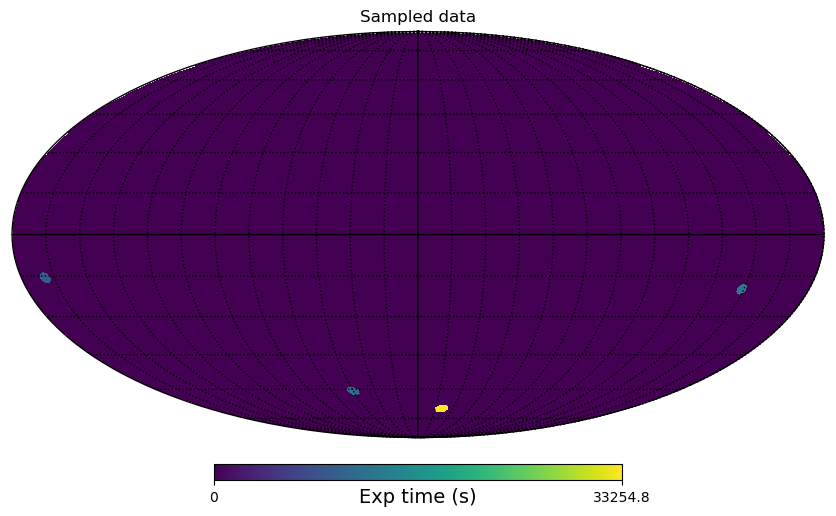

In [25]:
#Read data:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr = readFitsDir("../raw_data/MRS_goodTest",skymap=True,defr=False,sysError=0.1)

## Samples

In [4]:
#Sample file
fitsFile_ch1 = "../raw_data/MRS_all_data/jw02122-o003_t002_miri/jw02122-o003_t002_miri_ch2-shortmediumlong_x1d.fits"
sub1_ch1 = fits.open(fitsFile_ch1)
print(sub1_ch1.info())
print('###############################################################################')
print(sub1_ch1[0].header)
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data

Filename: ../raw_data/MRS_all_data/jw02122-o003_t002_miri/jw02122-o003_t002_miri_ch2-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     374   ()      
  1  EXTRACT1D     1 BinTableHDU     69   3224R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [64543B]   
None
###############################################################################
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  DATE    = '2024-07-07T11:31:01.890' / UTC date file created                     ORIGIN  = 'STSCI   '           / Organization responsible for creating file     TIMESYS = 'UTC     '           / p

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


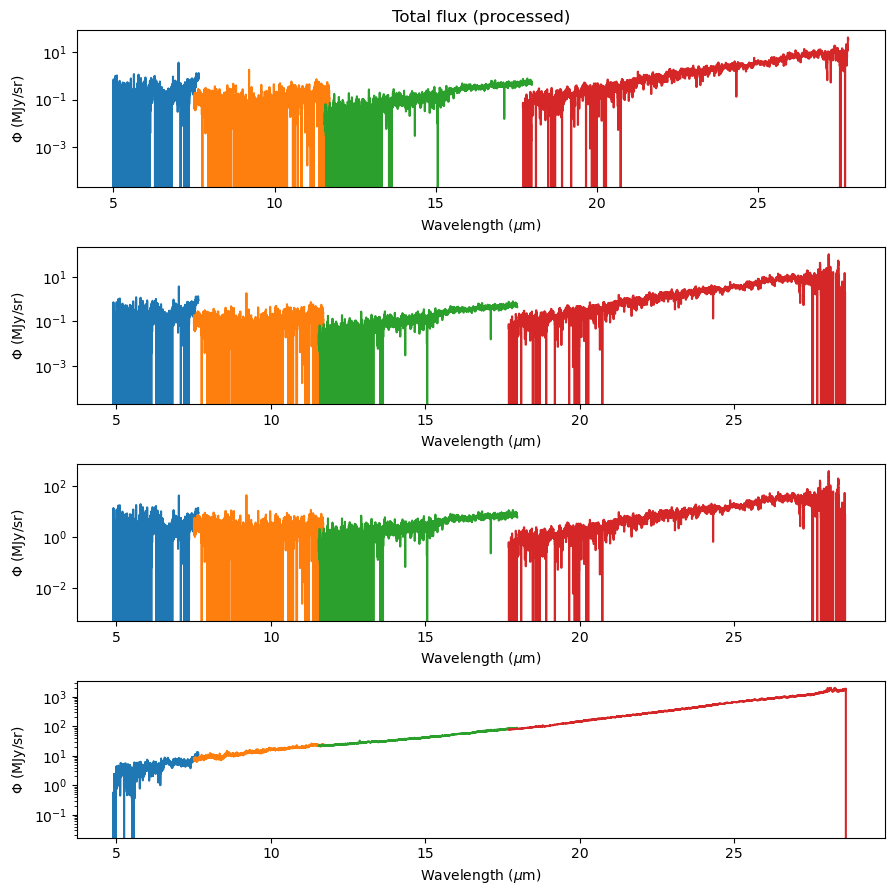

In [26]:
data_ch1, data_ch2, data_ch3, data_ch4,_,_,_ = readFits('../raw_data/MRS_data/jw02122-o003_t002_miri',
                                                        defringe=False,
                                                        sysErr=0.1,
                                                        #M1=15.25,M2=24.75
                                                       )

# Stack spectra

In [27]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=False)

Estimated log-signal-to-noise ratio:
[ 9.61748944 13.37344628 16.10958739 18.11995792 19.0676759 ]
[ 0.3269081  -0.34055088]


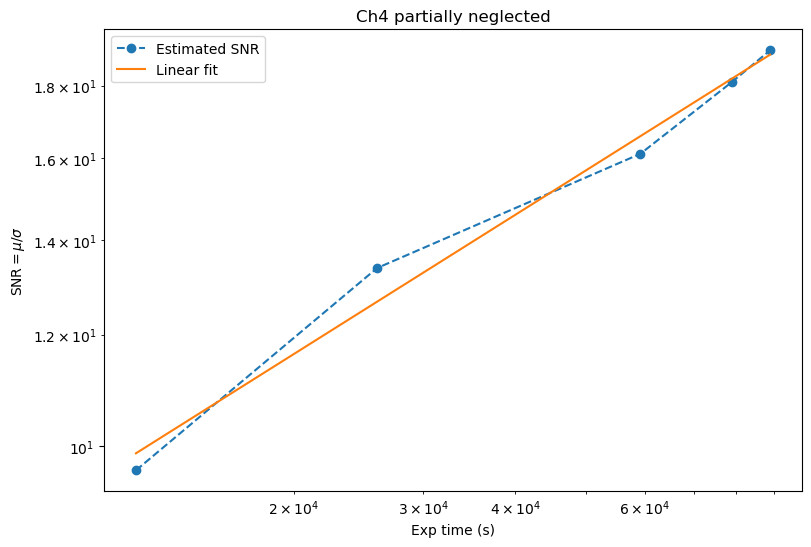

In [28]:
print('Estimated log-signal-to-noise ratio:')
print(SNR)
plt.figure(figsize=(9,6))
plt.plot(exptime,SNR,'--o',label='Estimated SNR')
plt.plot()
plt.ylabel('SNR$=\\mu/\\sigma$')
plt.xlabel('Exp time (s)')
plt.xscale('log')
plt.yscale('log')
#linear regression
p, lsq = linReg(np.log10(exptime),np.log10(SNR))
print(p)
plt.title('Ch4 partially neglected')
plt.plot(exptime,10**p[1]*exptime**p[0],'-',label='Linear fit')
plt.legend()

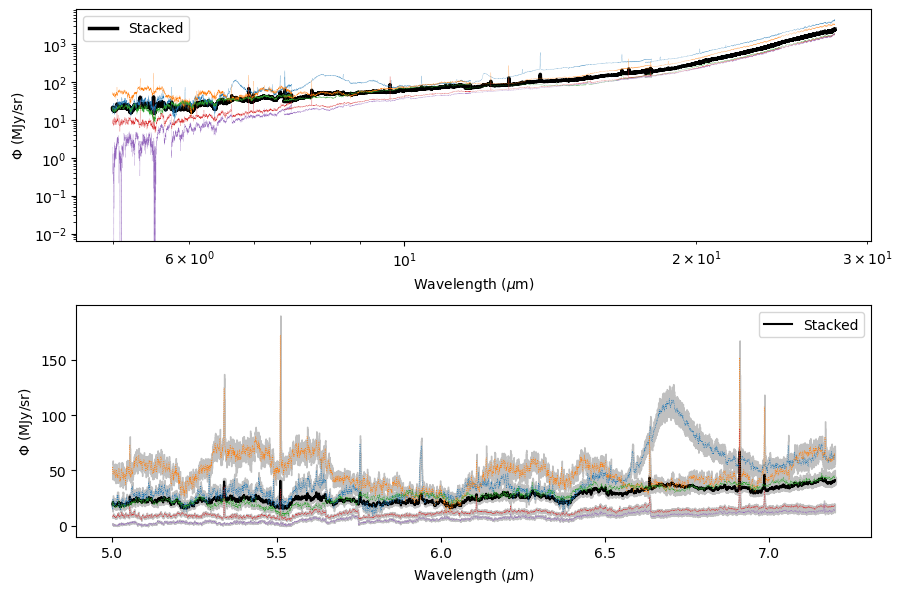

In [29]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5, M2=7.2, Ch1Arr=Ch1Arr, Ch2Arr=Ch2Arr, Ch3Arr=Ch3Arr, Ch4Arr=Ch4Arr)

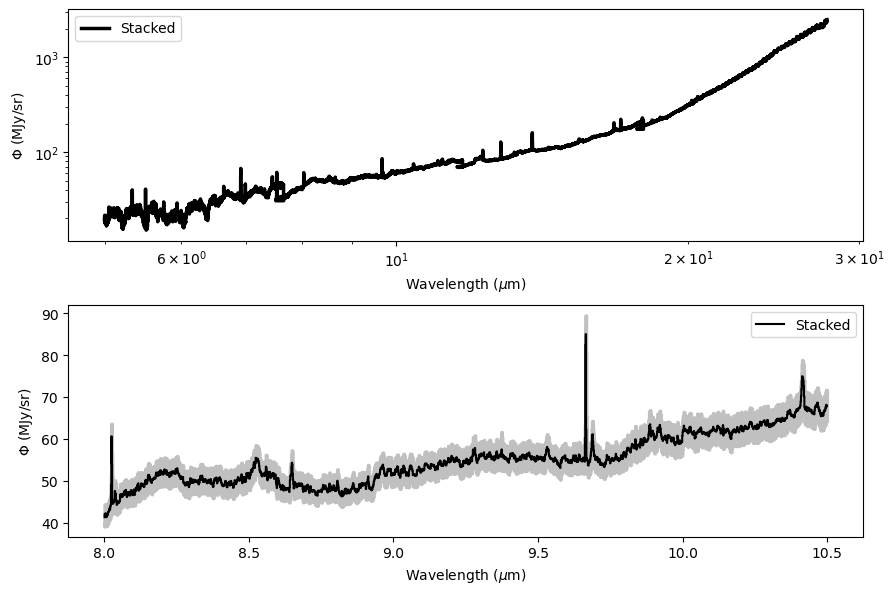

In [147]:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=8, M2=10.5)

In [31]:
#Output array files:
np.savez('stkData.npz', ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)
np.savez('metaData.npz', expt=exptArr, l=longArr, b=latArr)

# Testing

In [ ]:
print(Ch4Arr[2,2,-200:])

In [ ]:
print(stkdata_ch4[2,-200:])

* Really small SNR + wrong powerf
* undefined error in ch4